<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 3. Обучение с учителем. Методы классификации
## <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**Заполните код в клетках и выберите ответы в [веб-форме](https://goo.gl/TBwVhQ).**

**<a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster".**

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
plt.rcParams['figure.figsize'] = (12, 10)

**Функция для формирования csv-файла посылки на Kaggle:**

In [2]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки.**

In [3]:
train_df = pd.read_csv("../../data/titanic_train.csv") 
test_df = pd.read_csv("../../data/titanic_test.csv") 

In [4]:
y = train_df['Survived']

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Fischer, Mr. Eberhard Thelander",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"McNamee, Mrs. Neal (Eileen O'Leary)",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


**Заполним пропуски медианными значениями.**

In [8]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna('S', inplace=True)
test_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [9]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Pclass'], 
                                               prefix="PClass"),
                      pd.get_dummies(train_df['Sex'], prefix="Sex"),
                      pd.get_dummies(train_df['SibSp'], prefix="SibSp"),
                      pd.get_dummies(train_df['Parch'], prefix="Parch"),
                     pd.get_dummies(train_df['Embarked'], prefix="Embarked")],
                     axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Pclass'], 
                                             prefix="PClass"),
                      pd.get_dummies(test_df['Sex'], prefix="Sex"),
                      pd.get_dummies(test_df['SibSp'], prefix="SibSp"),
                      pd.get_dummies(test_df['Parch'], prefix="Parch"),
                    pd.get_dummies(test_df['Embarked'], prefix="Embarked")],
                     axis=1)

In [11]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,0,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,0,0,0,0,0,0,0,1


In [12]:
train_df.drop(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 
               'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], 
              axis=1, inplace=True)
test_df.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], 
             axis=1, inplace=True)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [13]:
train_df.shape, test_df.shape

((891, 24), (418, 25))

In [14]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [15]:
test_df.drop(['Parch_9'], axis=1, inplace=True)

In [16]:
train_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [17]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


891

## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [43]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label, sep=',')

In [91]:
# Ваш код здесь
first_tree = DecisionTreeClassifier(random_state=17, max_depth=2)


In [92]:
first_tree.fit(train_df, y)
#tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
#print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [93]:
# Ваш код здесь
first_predict = first_tree.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [95]:
# Ваш код здесь
write_to_submission_file(first_predict,'gender_submission.csv')

<font color='red'>Вопрос 1. </font> Каков результат первой посылки (дерево решений без настройки параметров) в публичном рейтинге соревнования Titanic?
- 0.746
- 0.756
- 0.766
- 0.776

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

[Text(334.8, 453.0, 'X[6] <= 0.5\nentropy = 0.473\nsamples = 891\nvalue = [549, 342]'),
 Text(167.4, 271.8, 'X[4] <= 0.5\nentropy = 0.383\nsamples = 314\nvalue = [81, 233]'),
 Text(83.7, 90.59999999999997, 'entropy = 0.1\nsamples = 170\nvalue = [9, 161]'),
 Text(251.10000000000002, 90.59999999999997, 'entropy = 0.5\nsamples = 144\nvalue = [72, 72]'),
 Text(502.20000000000005, 271.8, 'X[0] <= 6.5\nentropy = 0.306\nsamples = 577\nvalue = [468, 109]'),
 Text(418.5, 90.59999999999997, 'entropy = 0.444\nsamples = 24\nvalue = [8, 16]'),
 Text(585.9, 90.59999999999997, 'entropy = 0.28\nsamples = 553\nvalue = [460, 93]')]

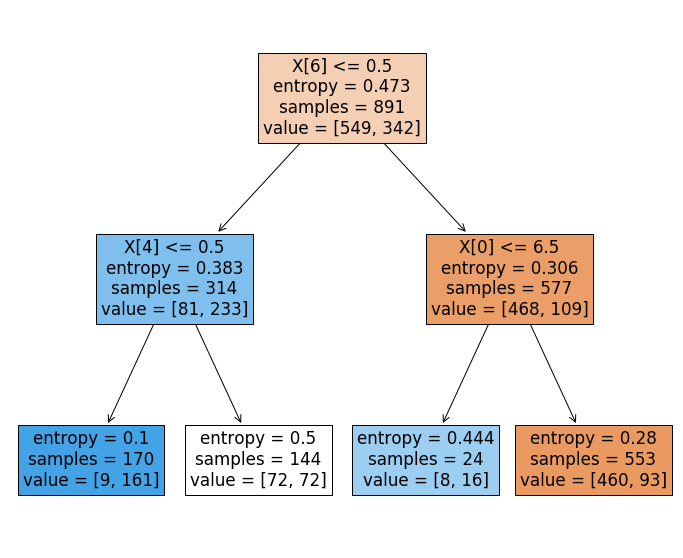

In [30]:
# Ваш код здесь
plot_tree(first_tree, filled=True)

<font color='red'>Вопрос 2. </font> Сколько признаков задействуются при прогнозе деревом решений глубины 2?
- 2
- 3 [+]
- 4
- 5

## 2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [ ]:

# tree params for grid search
tree_params = {'max_depth': list(range(1, 5)), 
               'min_samples_leaf': list(range(1, 5))}

# Ваш код здесь
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3,
                                                      random_state=17)

<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?
- max_depth=2, min_samples_leaf=1
- max_depth=2, min_samples_leaf=4
- max_depth=3, min_samples_leaf=2
- max_depth=3, min_samples_leaf=3

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?
- 0.77
- 0.79
- 0.81
- 0.83

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [ ]:
# Ваш код здесь

**Сформируйте файл посылки и отправьте на Kaggle.**

In [ ]:
# Ваш код здесь

<font color='red'>Вопрос 5. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?
- 0.7499
- 0.7599
- 0.7699
- 0.7799

## Ссылки:

 - <a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster"
 - <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"